## 定义模型

这里针对简单的环境建立一个ActorCritic网络，并且只针对离散动作空间进行处理，演员和评论家共享参数。

In [1]:
import torch.nn as nn

class ActorCritic(nn.Module):
    ''' A2C网络模型，包含一个Actor和Critic
    '''
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1), # 离散动作用softmax输出概率，这样就有策略梯度
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        # 返回动作概率分布和价值
        return probs, value 

### 定义智能体-A3C算法的实现

A3C算法实际上是在A2C算法的基础上实现的，算法原理相同。A2C算法的基本原理是在演员-评论家算法的基础上引入优势函数的概念。评论家是一个函数逼近器，输入当前观测到的状态，输出评分值，也就是Q值。而Q值实际上可以分解为两部分，即Q(s,a)=A(s,a)+V(s)。其中A(s,a)即为优势函数，评价的是在给定状态下当前选定动作相较于其他动作的好坏，它可以通过采样数据计算得出。A2C算法的核心就在于让评论家学习A(s,a)而不再是学习Q(s,a)。

损失函数一般分为三项，策略梯度损失，值残差和策略熵正则。其中，策略梯度损失用于不断优化提升reward，值残差用于使critic网络不断逼近真实的reward，策略熵正则能够为了保证action的多样性，增加智能体探索能力。

In [2]:

import torch
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical

class Policy:
    def __init__(self, cfg):
        self.model = ActorCritic(cfg.state_dim, cfg.action_dim, cfg.hidden_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.lr)
        self.device = torch.device(cfg.device)
        self.gamma = cfg.gamma
        
    def sample_action(self, state):
        state = torch.tensor(np.array(state), dtype=torch.float, device=self.device) # [batch_size, state_dim]
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        probs, self.value = self.model(state)
        dist = Categorical(probs)
        action = dist.sample()
        self.log_prob = dist.log_prob(action)
        return action.cpu().numpy()[0]

    def predict_action(self, state):
        state = torch.tensor(np.array(state), dtype=torch.float, device=self.device)
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        probs, value = self.model(state)
        return probs.argmax(dim=1).cpu().numpy()[0]
    
    def get_policy_transition(self):
        policy_transition = {'log_prob':self.log_prob.detach().cpu().numpy().item(), 'value': self.value.detach().cpu().numpy().item()}
        return policy_transition
        
    def learn(self, **kwargs):
        states, actions, returns= kwargs['states'], kwargs['actions'], kwargs['returns']
        values = kwargs['values']
        probs, values = self.model(states)
        dist = Categorical(probs)
        entropy = dist.entropy().mean()
        log_probs = dist.log_prob(actions).unsqueeze(1)
        advantages = returns - values
        actor_loss = - (log_probs * advantages.detach()).mean() 
        critic_loss = advantages.pow(2).mean()
        loss = actor_loss + 0.5* critic_loss - 0.001 * entropy
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return actor_loss.item(), critic_loss.item()

### 定义训练

在A3C的训练过程中，通过n_envs定义多个环境，构建多个工作进程，所有的工作进程都会在每个相同的时间步上进行环境交互，经过n_steps步的交互之后，将经验收集后一起计算梯度进行模型更新。需要注意的是，这里在多进程的构建上采用的是同步更新的方法，即在每个时间步上使用的是相同的模型和策略进行交互。

In [3]:
import copy
import gymnasium as gym
import ray

class Exp:
    ''' 经验类
    '''
    def __init__(self, **kwargs) -> None:
        for k,v in kwargs.items():
            setattr(self,k,v)

def compute_returns_for_exps(exps, gamma=0.95, gae_lambda=0.95):
    ''' 计算return，包括MC, TD, GAE
    '''
    def _get_exp_len(exps, max_step: int = 1):
        ''' get exp len
        '''
        exp_len = len(exps)
        if exp_len <= max_step or exps[-1].done:
            exp_len = max(exp_len, 0)
        else:
            exp_len = exp_len - max_step
        return exp_len
    exp_len = _get_exp_len(exps)
    next_value = exps[-1].value
    return_mc = 0
    return_td = next_value   
    adv_gae = 0
    returns_mc = []
    returns_td = []
    returns_gae = []
    for t in reversed(range(exp_len)):
        delta = exps[t].reward + gamma * next_value * (1 - exps[t].done) - exps[t].value
        adv_gae = delta + gamma * gae_lambda * (1 - exps[t].done) * adv_gae
        return_mc = exps[t].reward + gamma * return_mc * (1 - exps[t].done)
        return_td = exps[t].reward + gamma * return_td * (1 - exps[t].done)
        returns_mc.insert(0, return_mc)
        returns_td.insert(0, return_td)
        returns_gae.insert(0, adv_gae + exps[t].value)
        exps[t].return_mc = return_mc
        exps[t].return_td = return_td
        exps[t].adv_gae = adv_gae
        exps[t].return_gae = adv_gae + exps[t].value
        next_value = exps[t].value
    return_mc_normed = (returns_mc - np.mean(returns_mc)) / (np.std(returns_mc) + 1e-8)
    return_td_normed = (returns_td - np.mean(returns_td)) / (np.std(returns_td) + 1e-8)
    return_gae_normed = (returns_gae - np.mean(returns_gae)) / (np.std(returns_gae) + 1e-8)
    for t in range(exp_len):
        exps[t].return_mc_normed = return_mc_normed[t]
        exps[t].return_td_normed = return_td_normed[t]
        exps[t].return_gae_normed = return_gae_normed[t]
    exps = exps[:exp_len]
    return exps

@ray.remote
class EnvWorker:
    ''' 多进程worker
    '''
    def __init__(self, cfg, env, idx, **kwargs):
        if not ray.is_initialized():
            ray.init(ignore_reinit_error=True)
        self.cfg = cfg
        self.idx = idx
        self.env = env
        self.seed = cfg.seed + idx
        self.state, _  = self.env.reset(seed=self.seed)

    def run(self, policy):
        exps = []
        for _ in range(self.cfg.n_steps):
            action = policy.sample_action(self.state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            policy_transition = policy.get_policy_transition()
            interact_transition = {'state':self.state, 'action':action, 'reward':reward, 'next_state':next_state, 'done':terminated or truncated}
            exps.append(Exp(**interact_transition, **policy_transition))
            self.state = next_state
            if truncated or terminated:
                self.state, _ = self.env.reset(seed=self.seed)
        return exps
    
def evaluate_policy(env, policy, vis=False, n_episodes=10):
    state,_ = env.reset()
    if vis: env.render()
    terminated = False
    rewards = []
    for _ in range(n_episodes):
        ep_reward = 0
        ep_step = 0
        while True:
            action = policy.predict_action(np.array(state).reshape(1, -1))
            next_state, reward, terminated, truncated , _ = env.step(action)
            state = next_state
            # if vis: env.render()
            ep_reward += reward
            ep_step += 1
            if truncated or terminated or ep_step >=200:
                state,_ = env.reset()
                rewards.append(ep_reward)
                break
    return np.round(np.mean(rewards),3)

def train(cfg):
    ''' 训练
    '''
    ray.shutdown()
    ray.init()
    env = gym.make(cfg.env_id)
    setattr(cfg, "action_space", env.action_space)
    setattr(cfg, "state_dim", env.observation_space.shape[0])
    setattr(cfg, "action_dim", env.action_space.n)
    env_workers = [EnvWorker.remote(cfg, copy.deepcopy(env), idx) for idx in range(cfg.n_envs)]
    policy = Policy(cfg)
    frames, test_rewards = [], []
    threshold_reward_cnt = 0
    for i in range(cfg.max_frame):
        exps = ray.get([worker.run.remote(policy) for worker in env_workers])
        exps = [compute_returns_for_exps(exp, gamma = cfg.gamma, gae_lambda = cfg.gae_lambda) for exp in exps]
        exps = [exp for sublist in exps for exp in sublist]
        states = torch.tensor(np.array([exp.state for exp in exps]), dtype=torch.float, device=policy.device)
        actions = torch.tensor(np.array([exp.action for exp in exps]), dtype=torch.long, device=policy.device)
        log_probs = torch.tensor(np.array([exp.log_prob for exp in exps]), dtype=torch.float, device=policy.device)
        rewards = torch.tensor(np.array([exp.reward for exp in exps]), dtype=torch.float, device=policy.device)
        values = torch.tensor(np.array([exp.value for exp in exps]), dtype=torch.float, device=policy.device)
        returns = torch.tensor(np.array([exp.return_td_normed for exp in exps]), dtype=torch.float, device=policy.device).unsqueeze(1)
        actor_loss, critic_loss = policy.learn(states=states, actions=actions, log_probs=log_probs, values=values, returns=returns)
        if i % 20 == 0:
            frames.append(i)
            test_reward = evaluate_policy(env, policy)
            test_rewards.append(test_reward)
            print(f"Frame: {i}, Reward: {test_reward}")
            if test_reward >= cfg.threshold_reward:
                threshold_reward_cnt += 1
        if threshold_reward_cnt >= cfg.threshold_reward_cnt:
            print(f"Threshold reward reached over {cfg.threshold_reward_cnt} times, stop training!")
            break
    ray.shutdown()
    return {'frames':frames, 'rewards':test_rewards}

    

### 设置参数

In [4]:
class Config:
    def __init__(self):
        self.algo_name = "A3C"
        self.env_id = "CartPole-v1"
        self.mode = "train"
        self.n_envs = 10
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.max_frame = 1000000
        self.max_step = 200
        self.seed = 1
        self.hidden_dim = 256
        self.lr = 3e-4
        self.n_steps = 20
        self.n_epochs = 4
        self.threshold_reward = 200 # 目标reward
        self.threshold_reward_cnt = 10 # 如果连续N次达到目标reward则停止训练
        self.gamma = 0.95
        self.gae_lambda = 0.95

### 开始训练

2024-07-09 14:20:49,397	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Frame: 0, Reward: 23.8
Frame: 20, Reward: 8.9
Frame: 40, Reward: 13.6
Frame: 60, Reward: 15.5
Frame: 80, Reward: 138.0
Frame: 100, Reward: 131.4
Frame: 120, Reward: 124.1
Frame: 140, Reward: 131.4
Frame: 160, Reward: 138.0
Frame: 180, Reward: 138.2
Frame: 200, Reward: 180.9
Frame: 220, Reward: 157.8
Frame: 240, Reward: 197.3
Frame: 260, Reward: 160.2
Frame: 280, Reward: 130.1
Frame: 300, Reward: 195.7
Frame: 320, Reward: 172.1
Frame: 340, Reward: 165.4
Frame: 360, Reward: 186.3
Frame: 380, Reward: 106.9
Frame: 400, Reward: 138.5
Frame: 420, Reward: 200.0
Frame: 440, Reward: 200.0
Frame: 460, Reward: 196.6
Frame: 480, Reward: 182.7
Frame: 500, Reward: 196.3
Frame: 520, Reward: 200.0
Frame: 540, Reward: 197.5
Frame: 560, Reward: 182.4
Frame: 580, Reward: 200.0
Frame: 600, Reward: 164.6
Frame: 620, Reward: 176.2
Frame: 640, Reward: 200.0
Frame: 660, Reward: 193.1
Frame: 680, Reward: 200.0
Frame: 700, Reward: 200.0
Frame: 720, Reward: 200.0
Frame: 740, Reward: 200.0
Frame: 760, Reward: 200

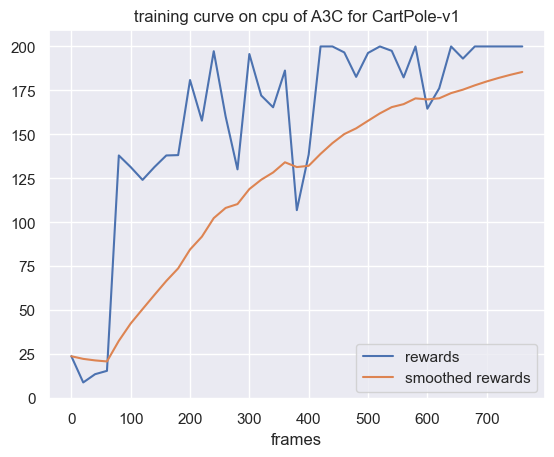

In [5]:
import ray
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

cfg = Config()
all_seed(cfg.seed)
res = train(cfg)
plot_rewards(cfg, res['frames'], res['rewards'])
